In [2]:
# Now let's do some feature engineering and model training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv(r"C:\Users\dhanu\OneDrive\Documents\books academic\p-1\datasets\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


C:\Users\dhanu\AppData\Local\Temp\ipykernel_6632\256328756.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(f_1[feature], bw_adjust=1, label='Class = 1', color='red')
C:\Users\dhanu\AppData\Local\Temp\ipykernel_6632\256328756.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(n_0[feature], bw_adjust=1, label='Class = 0', color='blue')


<Figure size 640x480 with 0 Axes>

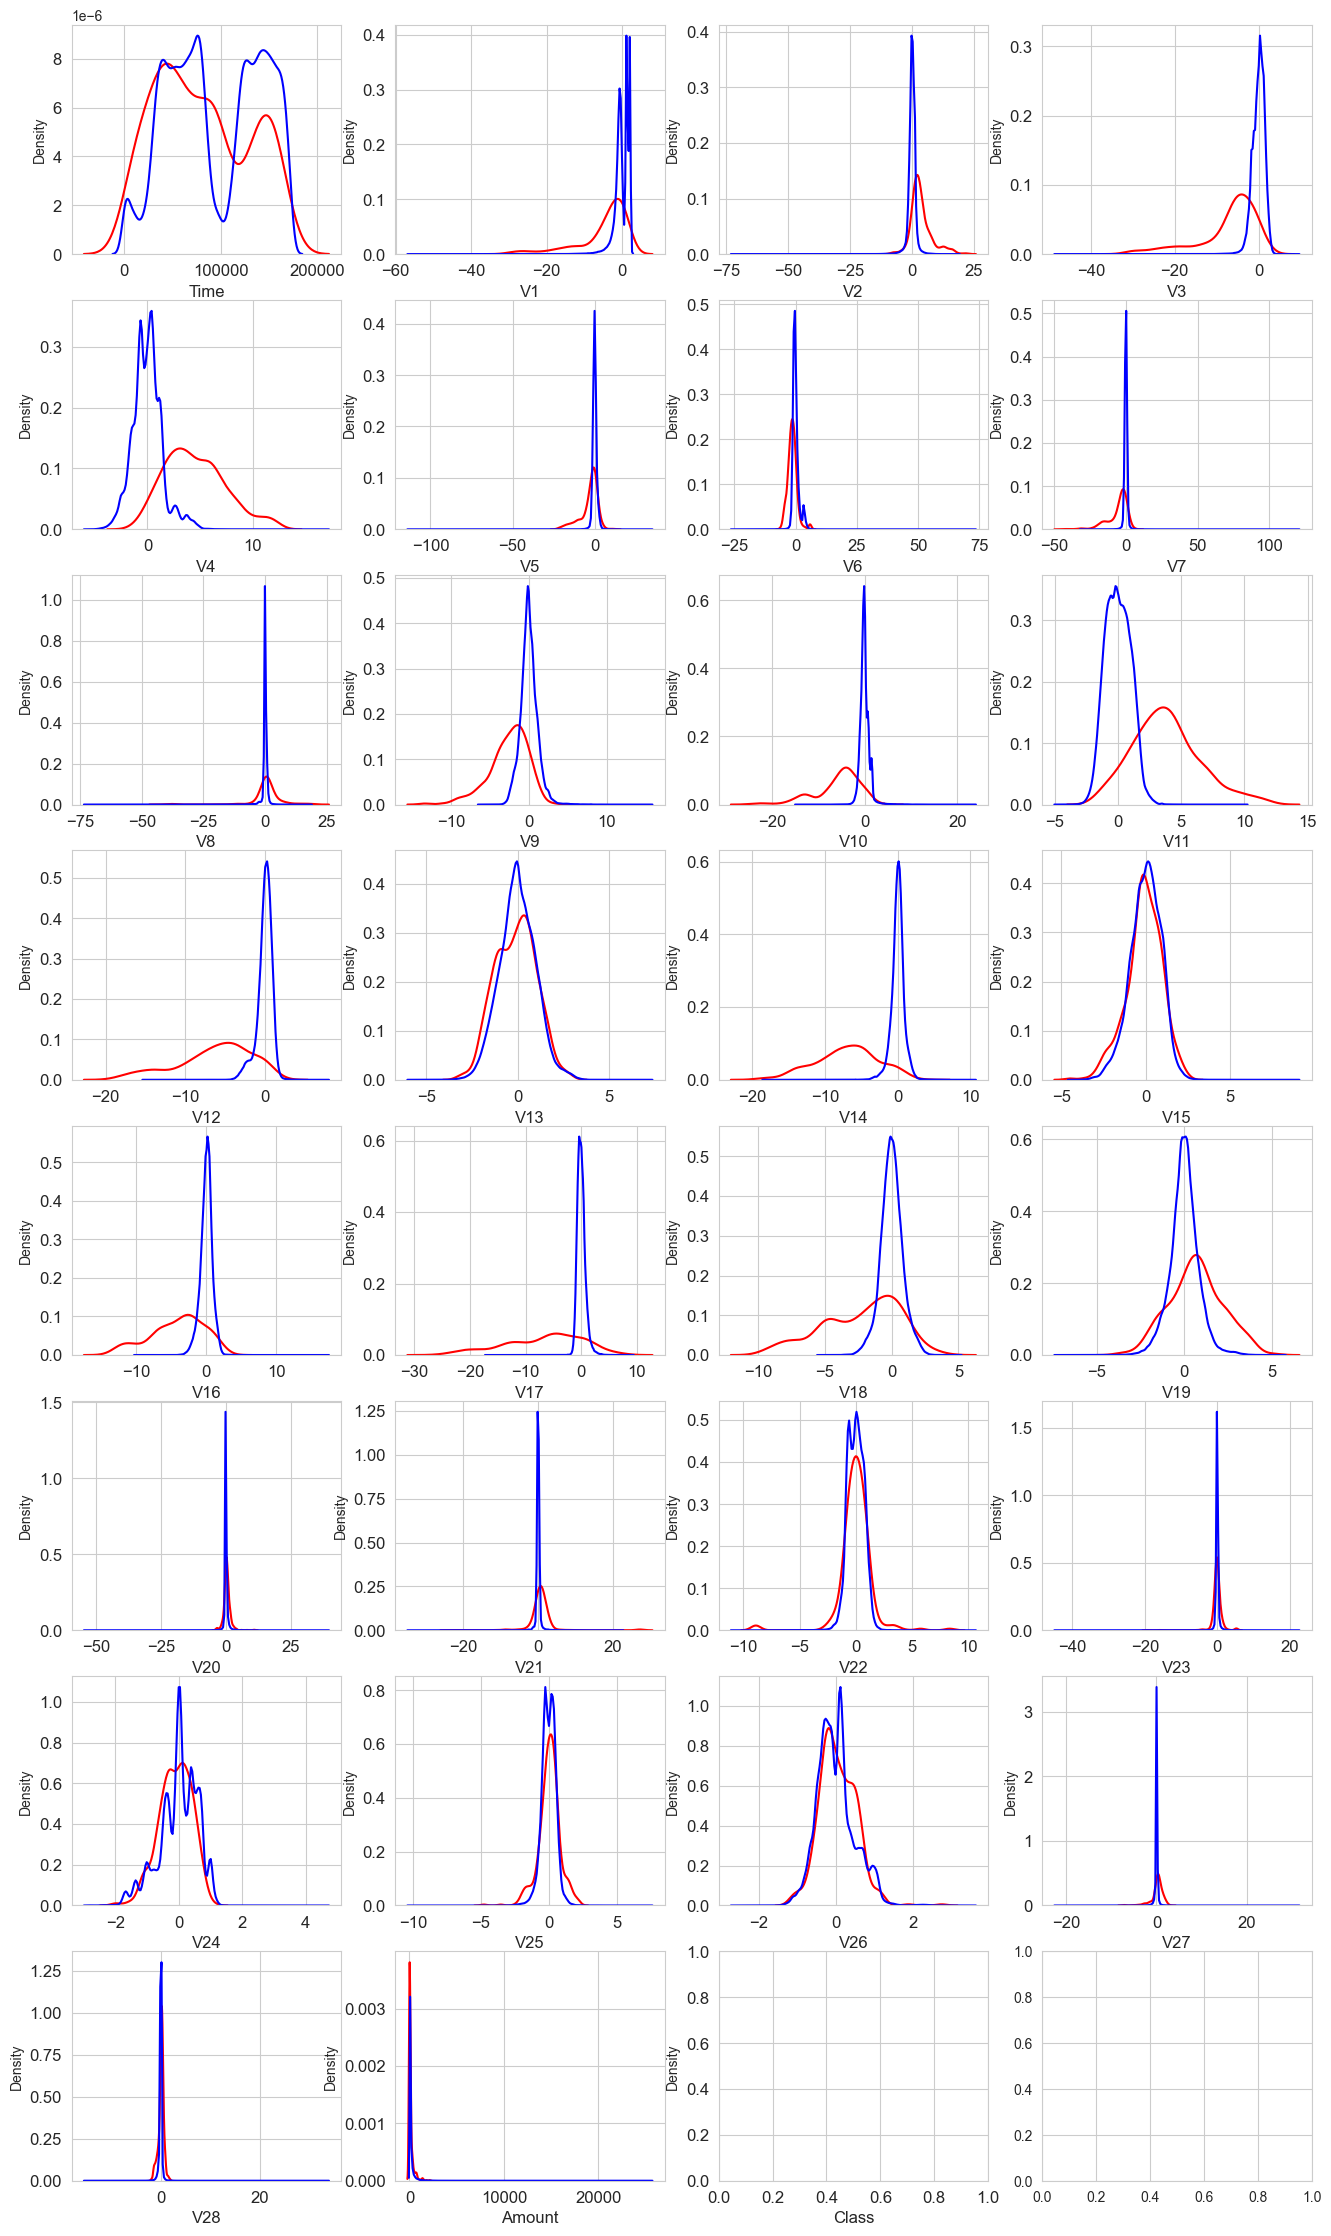

In [4]:
# separating the two classes to visualize the distribution of each feature
f_1 = df.loc[df['Class'] == 1]
n_0 = df.loc[df['Class'] == 0]

cols = df.columns.values
i = 0

sns.set_style('whitegrid')
plt.figure()

fig, ax = plt.subplots(8, 4, figsize=(16,28))

for feature in cols: # for each loop, run through each feature, and plot its density plot
    i += 1
    plt.subplot(8, 4, i)
    sns.kdeplot(f_1[feature], bw_adjust=1, label='Class = 1', color='red')
    sns.kdeplot(n_0[feature], bw_adjust=1, label='Class = 0', color='blue')
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


Based on the feature density plot that I made here, we can observe how each feature controls the class (transaction type) here. Some features like V4, V11, V10 have distinct distributions (mean values are not overlapping) for each class 0 and 1, and other features like V12, V14, V16 have partially overlapping distributions. Other features like V22,V25, V23 have similar profiles for both the classes (no distinction can be created between them). 

Upon careful observation, we can view class 1 distribution mostly consists of skewed data distribution. Like V3, V4, V12, V16, the class 1 distribution is skewed. This would be useful in classifying fraudulent samples from normal samples.

In [5]:
# since there are many irrelavant features, we will provide a score for each feature that will determine how well it can distinguish between the two classes
# we will use the ANOVA f-value for this purpose

from sklearn.feature_selection import f_classif    # ANOVA f-test scoring function
from sklearn.feature_selection import SelectKBest  # to select k best features based on the ANOVA score

features = df.drop(['Class'], axis=1) # features
labels = df['Class']                  # target variable

best_features  = SelectKBest(score_func = f_classif, k='all')  # select 'all' features and provide a score for each
fit = best_features.fit(features, labels)                      # fit the features and labels to the SelectKBest object, and provide a score for each feature

feature_scores = pd.DataFrame(fit.scores_, index = list(features.columns), columns=['ANOVA Score']) # create a dataframe with the feature names and their corresponding scores
feature_scores = feature_scores.sort_values(by='ANOVA Score', ascending=False) # sort the dataframe, showing the highest scoring features first

feature_scores.head(10) 


,ANOVA Score
V17,33979.168593
V14,28695.547788
V12,20749.822361
V10,14057.979985
V16,11443.349428
V3,11014.508305
V7,10349.605408
V11,6999.355047
V4,5163.832114
V18,3584.380605


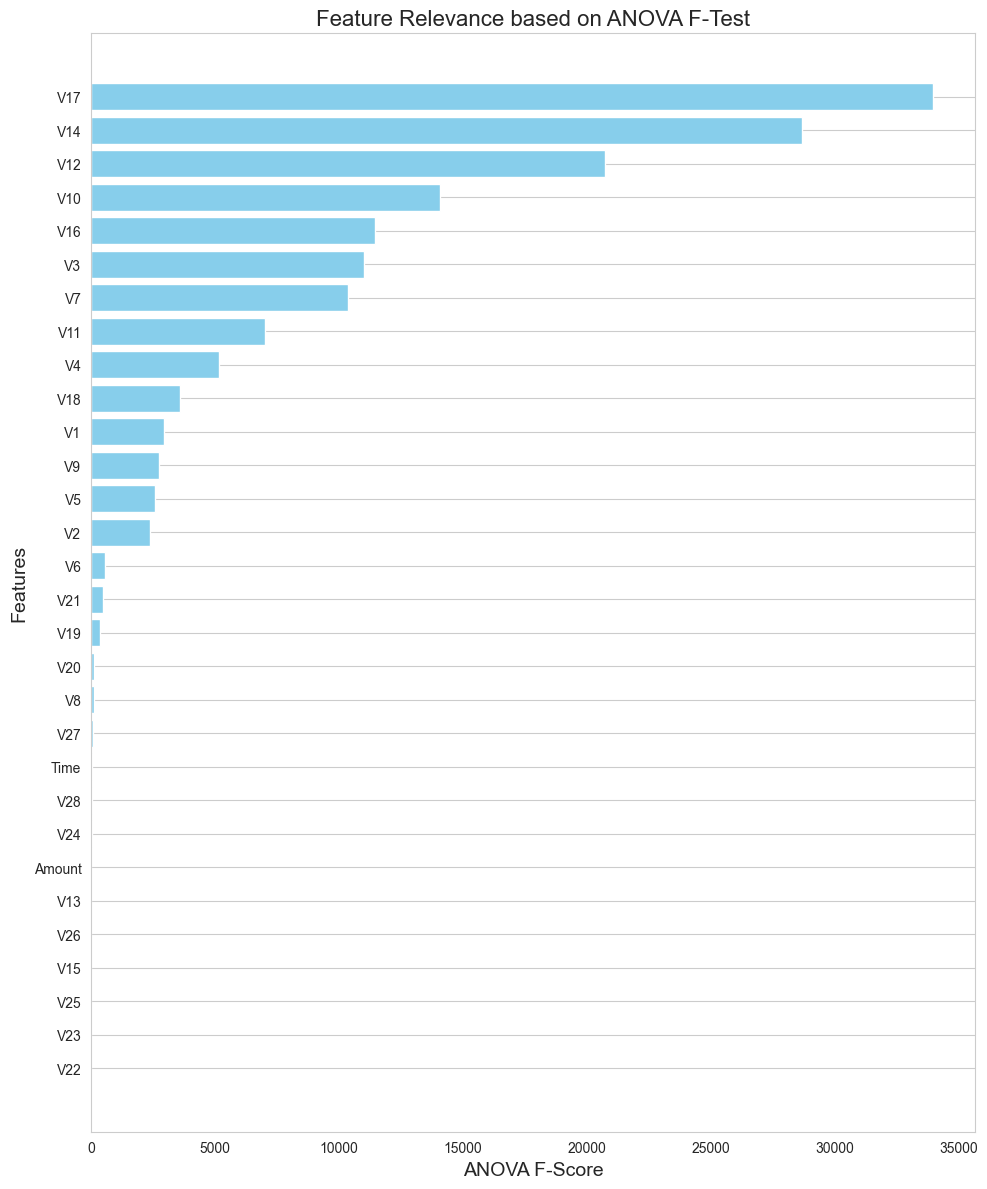

In [6]:
feature_scores = feature_scores.reset_index()
feature_scores.rename(columns={'index': 'Feature'}, inplace=True)

# Sort features by score (already sorted descending, but ensure ascending for horizontal barh)
feature_scores = feature_scores.sort_values(by='ANOVA Score', ascending=True)

# Plot high scored features at the top
plt.figure(figsize=(10, 12))
plt.barh(feature_scores['Feature'], feature_scores['ANOVA Score'], color='skyblue')
plt.xlabel('ANOVA F-Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Relevance based on ANOVA F-Test', fontsize=16)
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Based on ANOVA score, the top features are V17, V14, V12, V10, V16.

In [7]:
# another test for feature importance is correlation matrix
# we can find the correlation scores of all the features with respect to the target variable (Class) and then plot a horizontal bar chart to visualize the most important features

corr = df.corrwith(df["Class"]).sort_values(ascending=False).to_frame() 
# find the correlation scores of all features with respect to the target variable (Class), and convert to dataframe
corr.columns = ['Correlation']

corr.head(7)


,Correlation
Class,1.000000
V11,0.154876
V4,0.133447
V2,0.091289
V21,0.040413
V19,0.034783
V20,0.020090


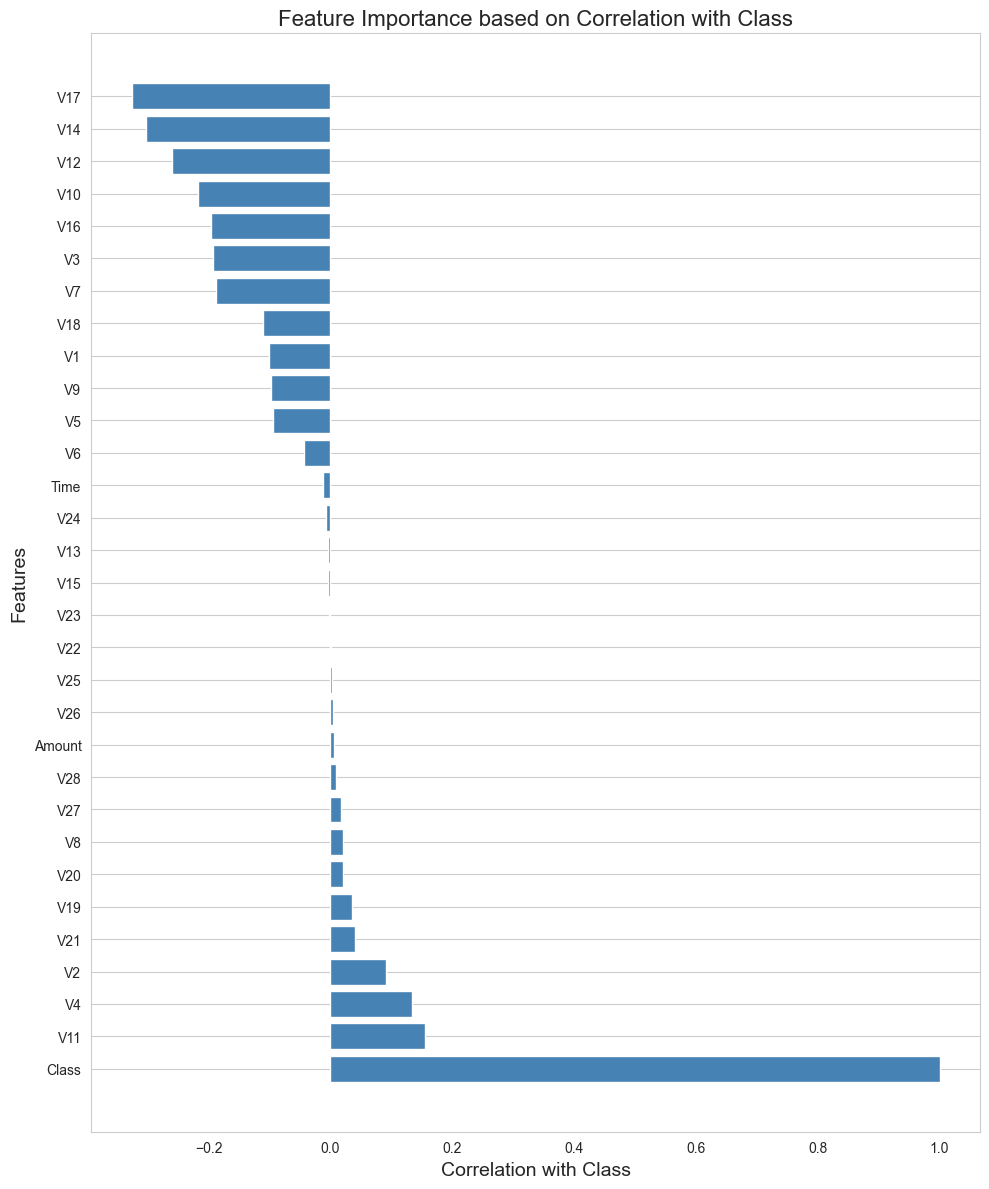

In [8]:
# plotting the horizontal bar chart for correlation scores
fig, ax = plt.subplots(figsize=(10, 12))
plt.barh(corr.index, corr['Correlation'], color='steelblue')
plt.xlabel('Correlation with Class', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance based on Correlation with Class', fontsize=16)
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Any features which have correlation scores in between -0.1 and 0.1 can be neglected, since they don't correlate significantly. Rest of the features can be directly used for model training.

We will be using these two tests (ANOVA and Correlation) for feature selection.

ANOVA : Remove features with a score of less than 50
Correlation : Remove features with scores in range of [-0.1,0.1]


In [9]:
corr = corr[corr['Correlation'].abs() > 0.1]  # filter out features with correlation scores in between -0.1 and 0.1
corr

,Correlation
Class,1.000000
V11,0.154876
V4,0.133447
V1,-0.101347
V18,-0.111485
V7,-0.187257
V3,-0.192961
V16,-0.196539
V10,-0.216883
V12,-0.260593


These are the features that we will include in the final dataset for correlation based feature selection


In [10]:
# Correlation based feature selection dataset

df_corr = df[['V1','V3','V4','V7','V10','V11','V12','V14','V16','V17','V18','Class']]
df_corr.head()

,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,1.191857,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,-1.358354,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.966272,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,-1.158233,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0


In [11]:
# ANOVA based feature selection dataset

df_anova = df.copy(deep  = True)
anova_features = feature_scores[feature_scores['ANOVA Score'] > 50]['Feature'].tolist() # get the features with ANOVA score greater than 50
anova_features.append('Class') # append the target variable to the list

df_anova = df_anova.drop(columns=[col for col in df_anova.columns if col not in anova_features]) # drop the columns which are not in the anova_features list
df_anova.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V20,V21,V27,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.133558,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.008983,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,-0.055353,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.062723,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.219422,0


Both the datasets are finalized. Now its time to select models and train them with these 2 sets of data.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.75      0.70      0.73       148

    accuracy                           1.00     85443
   macro avg       0.88      0.85      0.86     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


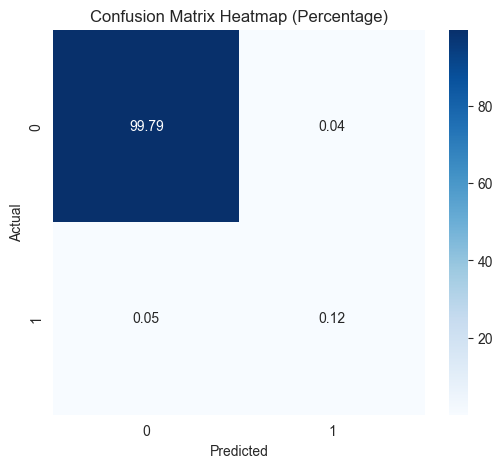

ROC AUC Score: 0.8511520430683336


In [12]:
# dry run without altering the dataset

features = df.drop(['Class'], axis=1) 
labels = df['Class']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)  

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

classifier_lr = LogisticRegression(random_state = 0,C=10,penalty= 'l2') 
classifier_lr.fit(x_train, y_train)

y_pred = classifier_lr.predict(x_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (Percentage)')
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Based on this dry run, where the dataset has not been altered, the accuracy shows 100%, but it is highly misleading, because it is favoring the majority class only.
Most of the fraud samples are not being detected by the model (about 30% are missed), and the ROC-AUC score is around 85%, which is quite low. 

Let's tweak the dataset a bit so that we can optimize this even better.